In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

# ✅ Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [18]:
""" 
---------------------------
MODEL STUFF
--------------------------- 
"""

# Define Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, num_heads=4, num_layers=2, dim_feedforward=128, dropout=0.2, seq_len=30):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, dim_feedforward)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_len, dim_feedforward))  # Dynamic encoding
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_feedforward,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(dim_feedforward, 1)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding  # Apply embedding + positional encoding
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])  # Take last time step's output
        return x

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------

# Create sequences for time-series data
def create_sequences(data, dates, seq_len=30):
    X, y, y_dates = [], [], []
    data_array = data  # data is already a NumPy array
    for i in range(len(data_array) - seq_len):
        X.append(data_array[i:i+seq_len])
        y.append(data_array[i+seq_len, 0])
        y_dates.append(dates[i+seq_len])
    return np.array(X), np.array(y), np.array(y_dates)

# Inverse scale predictions for the target (first column)
def inverse_scale_predictions(predictions, scaler):
    num_features = scaler.min_.shape[0]
    dummy = np.zeros((predictions.shape[0], num_features))
    dummy[:, 0] = predictions.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

# ---------------------------
# TRAINING & TUNING FUNCTIONS
# ---------------------------

def train_evaluate_model(params, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=20):
    # Create a Transformer model using the hyperparameters
    model = TransformerModel(
        input_size=X_train_tensor.shape[2],
        num_heads=4,  # fixed value; you can add tuning if desired
        num_layers=params['num_layers'],
        dim_feedforward=params['hidden_size'],  # using 'hidden_size' as feedforward dim
        dropout=params['dropout'],
        seq_len=X_train_tensor.shape[1]
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.MSELoss()
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)
    
    for _ in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(batch_X), batch_y)
            loss.backward()
            optimizer.step()
    # Evaluate on test set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            val_loss += criterion(model(batch_X), batch_y).item()
    return val_loss / len(test_loader)

# Objective function for hyperparameter tuning with Optuna
def objective(trial, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor):
    params = {
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 256]),
        'num_layers': trial.suggest_int('num_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128])
    }
    return train_evaluate_model(params, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

# ---------------------------
# MAIN PIPELINE FUNCTION (Transformer)
# ---------------------------
def transformer_model_pipeline(data, seq_len=30, tuning=False, best_params={'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3, 
    'learning_rate': 1e-4, 'batch_size': 32}):

    if isinstance(data, pd.Series):
        data = data.to_frame()

    # Normalize data: fit scaler on first 90% of data, then transform all
    train_size = int(0.9 * len(data))
    scaler = MinMaxScaler()
    scaler.fit(data[:train_size])
    data_scaled = scaler.transform(data)
    
    # Create sequences and split into train/test sets based on original indices (using df.index)
    X, y, y_dates = create_sequences(data_scaled, data.index, seq_len)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    y_dates_train, y_dates_test = y_dates[:train_size], y_dates[train_size:]
    
    # Convert sequences to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
    
    if tuning:
        # Hyperparameter tuning with Optuna (use fewer trials for speed)
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor),
                       n_trials=10)
        best_params = study.best_params
        print("Best Hyperparameters:", best_params)
    
    # Train final Transformer model using the best (or default) hyperparameters
    final_model = TransformerModel(
        input_size=X_train_tensor.shape[2],
        num_heads=4,
        num_layers=best_params['num_layers'],
        dim_feedforward=best_params['hidden_size'],
        dropout=best_params['dropout'],
        seq_len=X_train_tensor.shape[1]
    ).to(device)
    
    optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
    criterion = nn.MSELoss()
    batch_size = best_params['batch_size']
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    epochs = 50
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        final_model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            loss = criterion(final_model(batch_X), batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
        
        final_model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                val_loss += criterion(final_model(batch_X), batch_y).item()
        val_losses.append(val_loss / len(test_loader))
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Val Loss", marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.show()
    
    # Evaluate final model
    final_model.eval()
    with torch.no_grad():
        y_pred_tensor = final_model(X_test_tensor).cpu().numpy()
        y_true_tensor = y_test_tensor.cpu().numpy()
    
    y_pred = inverse_scale_predictions(y_pred_tensor, scaler)
    y_true = inverse_scale_predictions(y_true_tensor, scaler)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    
    plt.figure(figsize=(12,6))
    plt.plot(y_dates_test, y_true, label="Actual VN-INDEX", marker='o', color="blue")
    plt.plot(y_dates_test, y_pred, label="Predicted VN-INDEX", marker='s', linestyle="dashed", color="red")
    plt.xlabel("Date")
    plt.ylabel("VN-INDEX")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.title("Transformer Predictions vs. Actual VN-INDEX")
    plt.show()

    # Calculate percentage change between successive values for both actual and predicted series
    actual_pct_change = np.diff(y_true.flatten()) / y_true.flatten()[:-1] * 100
    pred_pct_change = np.diff(y_pred.flatten()) / y_pred.flatten()[:-1] * 100

    plt.figure(figsize=(12,6))
    plt.plot(actual_pct_change, label="Actual % Change", marker='s', color="blue")
    plt.plot(pred_pct_change, label="Predicted % Change", marker='s', color="red")
    plt.xlabel("Time Step")
    plt.ylabel("Percentage Change (%)")
    plt.title("Percentage Change Comparison: Actual vs. Predicted")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Print table of first 10 results
    results_df = pd.DataFrame({
        "Date": y_dates_test,
        "Actual VN-INDEX": y_true,
        "Predicted VN-INDEX": y_pred
    })
    print("Predicted vs. Actual VN-INDEX (Test Set):")
    print(results_df)
    
    return final_model, X_test_tensor, scaler, y_pred

# ---------------------------
# FUTURE PREDICTION FUNCTION
# ---------------------------
def future_prediction(X_test, y_pred, data, scaler, model, num_days=30):

    if isinstance(data, pd.Series):
        data = data.to_frame()

    model.eval()
    input_seq = X_test[-1].cpu().numpy()
    future_preds = []
    for _ in range(num_days):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(input_tensor).cpu().numpy()[0, 0]
        future_preds.append(pred)
        input_seq = np.roll(input_seq, -1, axis=0)
        input_seq[-1, 0] = pred  # update the VN-INDEX feature
    future_preds = inverse_scale_predictions(np.array(future_preds).reshape(-1,1), scaler)
    
    last_date = data.index[-1]
    future_dates = []
    while len(future_dates) < num_days:
        last_date += pd.Timedelta(days=1)
        if last_date.weekday() < 5:
            future_dates.append(last_date)
    
    plt.figure(figsize=(12,6))
    plt.plot(future_dates, future_preds, marker='o', linestyle="dashed", color="red", label="Predicted VN-INDEX")
    plt.xlabel("Date")
    plt.ylabel("VN-INDEX")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.title(f"Predicted VN-INDEX for Next {num_days} Trading Days")
    plt.show()

    # Overlay historical data with future predictions
    historical_dates = data.index[-100:]
    historical_values = data.iloc[-100:, 0].values  # assuming VN-INDEX is in the first column
    plt.figure(figsize=(12,6))
    plt.plot(historical_dates, historical_values, label="Historical VN-INDEX", color="blue")
    plt.plot(historical_dates, y_pred[-100:], label="Test Predictions", color="red")
    plt.plot(future_dates, future_preds, color="green", label="Future Predicted VN-INDEX")    
    plt.xlabel("Date")
    plt.ylabel("VN-INDEX")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.title("Historical VN-INDEX with Future Predictions")
    plt.show()
    
    future_df = pd.DataFrame({"Date": future_dates, "Predicted VN-INDEX": future_preds})
    print(future_df)

# ---------------------------
# Example Usage:
# ---------------------------
# Assuming 'data' is a NumPy array of your features (e.g., VN_Index_Close values)
# and 'df' is your DataFrame with dates as index.
# For example:
# data = df["VN_Index_Close"].values.reshape(-1, 1)
#
# To run the Transformer pipeline (tuning optional):
# final_model, X_test_tensor, scaler = transformer_model_pipeline(data, df, tuning=False)
# future_prediction(X_test_tensor, df, scaler, final_model, num_days=30)

In [19]:
""" DATA FEATURES """
def compute_RSI(series, window=14):
        delta = series.diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
        RS = gain / loss
        return 100 - (100 / (1 + RS))

def lag_features_indicators(df, numerical_columns):
    copy_df = df.copy()
    # 📌 Apply Lagged Features to Every Column
    lag_days = [1, 2, 3, 5, 10]  # Lags of 1, 2, 3, 5, and 10 days
    for col in numerical_columns:
        for lag in lag_days:
            copy_df[f'{col}_Lag{lag}'] = copy_df[col].shift(lag)

    # 📌 Apply Simple Moving Averages (SMA) and Exponential Moving Averages (EMA) to Every Column
    for col in numerical_columns:
        copy_df[f'{col}_SMA_10'] = copy_df[col].rolling(window=10).mean()
        copy_df[f'{col}_SMA_20'] = copy_df[col].rolling(window=20).mean()
        copy_df[f'{col}_EMA_10'] = copy_df[col].ewm(span=10, adjust=False).mean()
        copy_df[f'{col}_EMA_20'] = copy_df[col].ewm(span=20, adjust=False).mean()

    # 📌 Apply Relative Strength Index (RSI) to Every Column
    for col in numerical_columns:
        copy_df[f'{col}_RSI_14'] = compute_RSI(copy_df[col])

    # 📌 Apply Moving Average Convergence Divergence (MACD) to Every Column
    for col in numerical_columns:
        copy_df[f'{col}_EMA_12'] = copy_df[col].ewm(span=12, adjust=False).mean()
        copy_df[f'{col}_EMA_26'] = copy_df[col].ewm(span=26, adjust=False).mean()
        copy_df[f'{col}_MACD'] = copy_df[f'{col}_EMA_12'] - copy_df[f'{col}_EMA_26']

    # 📌 Drop NA values caused by shifting and rolling
    copy_df.dropna(inplace=True)

    return copy_df

def quicky_data(df):
    # 🕒 Convert 'Date' to datetime and set as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # 📌 Drop unnecessary columns
    if 'Index' in df.columns:
        df.drop(columns=['Index'], inplace=True)
    
    return df

In [20]:
# 📂 Load dataset
file_path_1 = "../ready_data/cleaned_hose_historical_data.csv"
df_1 = pd.read_csv(file_path_1)
df_1 = quicky_data(df_1)

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Train Loss: 0.0744, Val Loss: 0.0421
Epoch 2/50, Train Loss: 0.0211, Val Loss: 0.0012
Epoch 3/50, Train Loss: 0.0127, Val Loss: 0.0020
Epoch 4/50, Train Loss: 0.0090, Val Loss: 0.0008
Epoch 5/50, Train Loss: 0.0070, Val Loss: 0.0002
Epoch 6/50, Train Loss: 0.0057, Val Loss: 0.0008
Epoch 7/50, Train Loss: 0.0048, Val Loss: 0.0009
Epoch 8/50, Train Loss: 0.0040, Val Loss: 0.0009
Epoch 9/50, Train Loss: 0.0035, Val Loss: 0.0008
Epoch 10/50, Train Loss: 0.0029, Val Loss: 0.0001
Epoch 11/50, Train Loss: 0.0027, Val Loss: 0.0003
Epoch 12/50, Train Loss: 0.0024, Val Loss: 0.0006
Epoch 13/50, Train Loss: 0.0021, Val Loss: 0.0003
Epoch 14/50, Train Loss: 0.0020, Val Loss: 0.0004
Epoch 15/50, Train Loss: 0.0020, Val Loss: 0.0002
Epoch 16/50, Train Loss: 0.0016, Val Loss: 0.0001
Epoch 17/50, Train Loss: 0.0016, Val Loss: 0.0006
Epoch 18/50, Train Loss: 0.0014, Val Loss: 0.0001
Epoch 19/50, Train Loss: 0.0014, Val Loss: 0.0008
Epoch 20/50, Train Loss: 0.0013, Val Loss: 0.0001
Epoch 21/

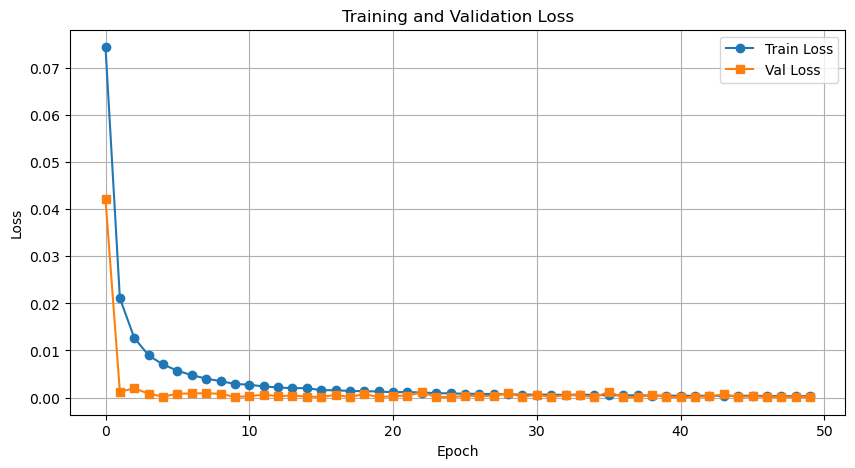

RMSE: 12.6252, MAE: 9.2436, R²: 0.9606


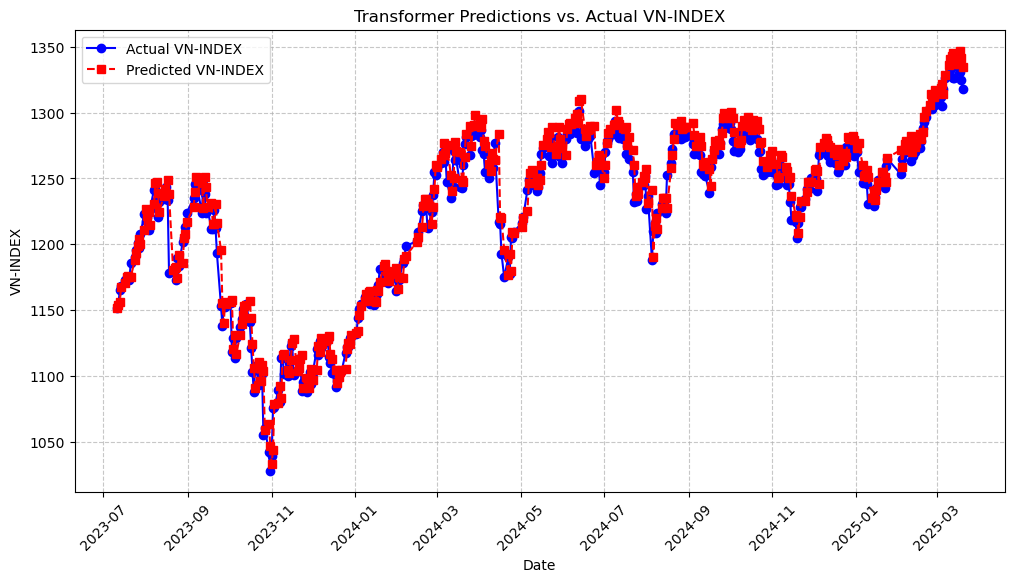

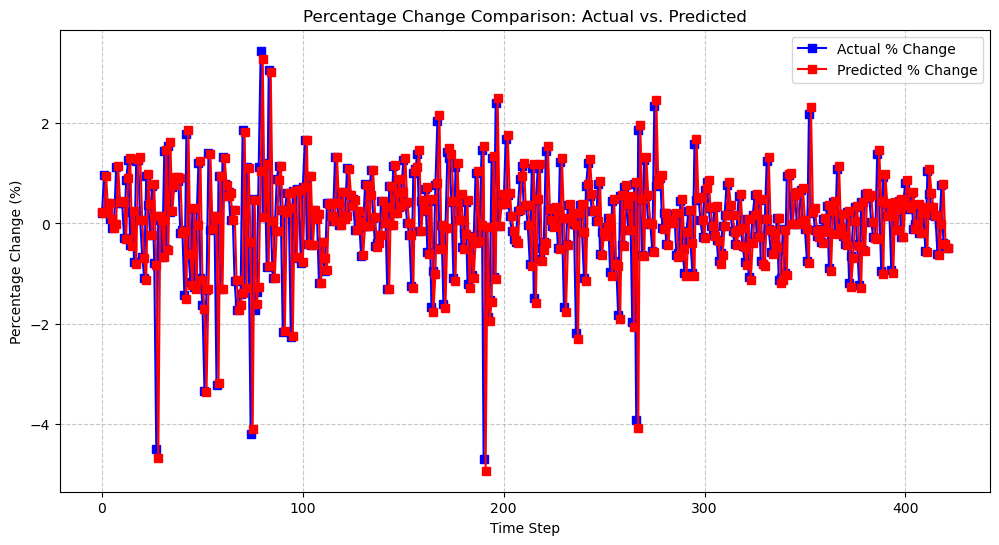

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-07-11      1151.769999         1151.404442
1   2023-07-12      1154.200033         1154.114019
2   2023-07-13      1165.420009         1156.502973
3   2023-07-14      1168.400035         1167.542907
4   2023-07-17      1173.130004         1170.533724
..         ...              ...                 ...
418 2025-03-14      1326.150001         1336.588765
419 2025-03-17      1336.259972         1336.464215
420 2025-03-18      1330.969991         1346.902363
421 2025-03-19      1324.629967         1341.453611
422 2025-03-20      1318.079998         1334.885915

[423 rows x 3 columns]


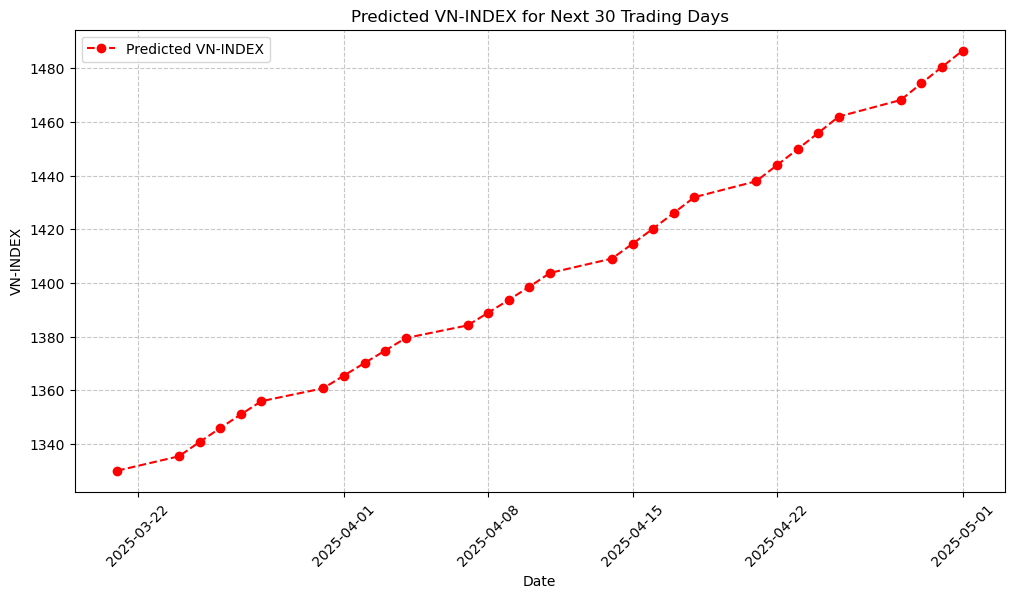

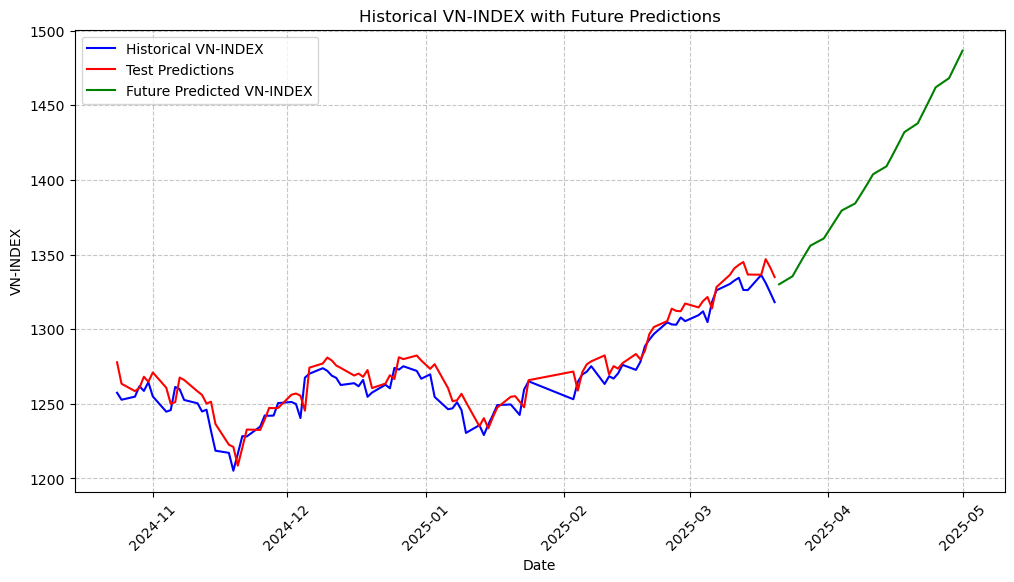

         Date  Predicted VN-INDEX
0  2025-03-21         1330.049277
1  2025-03-24         1335.426581
2  2025-03-25         1340.731746
3  2025-03-26         1345.935713
4  2025-03-27         1351.011740
5  2025-03-28         1355.955509
6  2025-03-31         1360.777734
7  2025-04-01         1365.489128
8  2025-04-02         1370.172544
9  2025-04-03         1374.804476
10 2025-04-04         1379.483114
11 2025-04-07         1384.199518
12 2025-04-08         1388.929795
13 2025-04-09         1393.714485
14 2025-04-10         1398.635133
15 2025-04-11         1403.755476
16 2025-04-14         1409.091084
17 2025-04-15         1414.610203
18 2025-04-16         1420.284855
19 2025-04-17         1426.084366
20 2025-04-18         1431.975207
21 2025-04-21         1437.920771
22 2025-04-22         1443.883522
23 2025-04-23         1449.829471
24 2025-04-24         1455.883245
25 2025-04-25         1462.007464
26 2025-04-28         1468.161895
27 2025-04-29         1474.328890
28 2025-04-30 

In [21]:
# 📊 Select only VN-INDEX for prediction
data = df_1["VN_Index_Close"]

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = transformer_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Train Loss: 0.0560, Val Loss: 0.0160
Epoch 2/50, Train Loss: 0.0198, Val Loss: 0.0053
Epoch 3/50, Train Loss: 0.0113, Val Loss: 0.0059
Epoch 4/50, Train Loss: 0.0078, Val Loss: 0.0028
Epoch 5/50, Train Loss: 0.0061, Val Loss: 0.0021
Epoch 6/50, Train Loss: 0.0045, Val Loss: 0.0020
Epoch 7/50, Train Loss: 0.0037, Val Loss: 0.0013
Epoch 8/50, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 9/50, Train Loss: 0.0026, Val Loss: 0.0014
Epoch 10/50, Train Loss: 0.0021, Val Loss: 0.0012
Epoch 11/50, Train Loss: 0.0019, Val Loss: 0.0021
Epoch 12/50, Train Loss: 0.0018, Val Loss: 0.0015
Epoch 13/50, Train Loss: 0.0015, Val Loss: 0.0012
Epoch 14/50, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 15/50, Train Loss: 0.0014, Val Loss: 0.0010
Epoch 16/50, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 17/50, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 18/50, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 19/50, Train Loss: 0.0010, Val Loss: 0.0011
Epoch 20/50, Train Loss: 0.0009, Val Loss: 0.0013
Epoch 21/

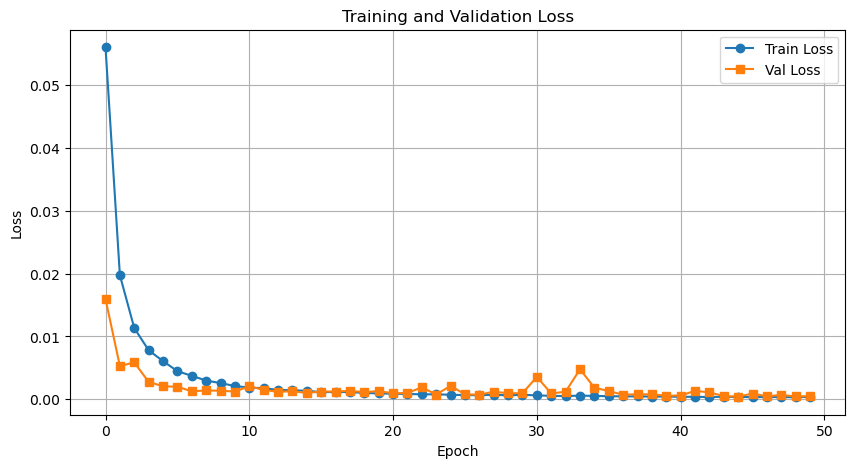

RMSE: 22.1318, MAE: 17.3103, R²: 0.8790


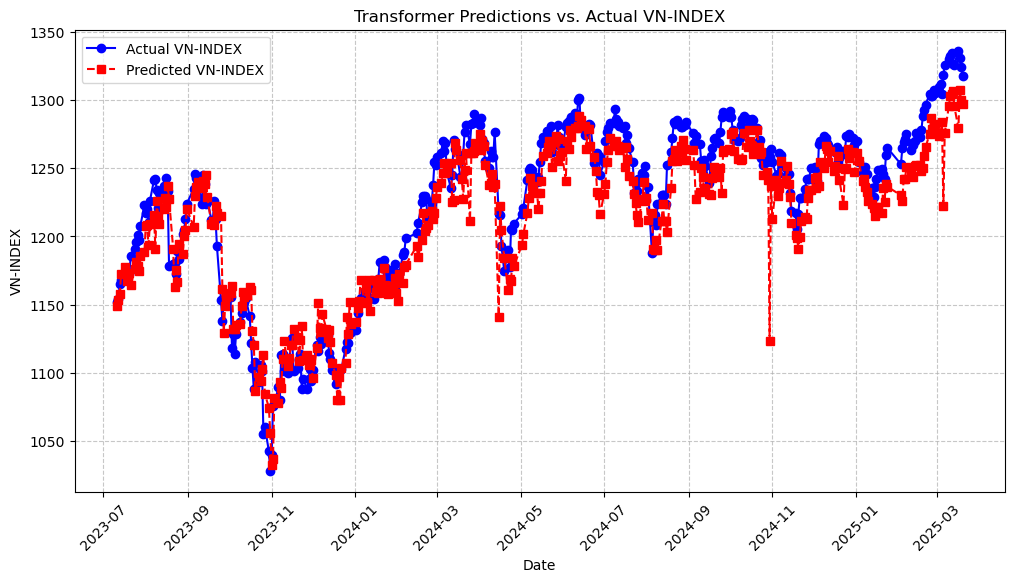

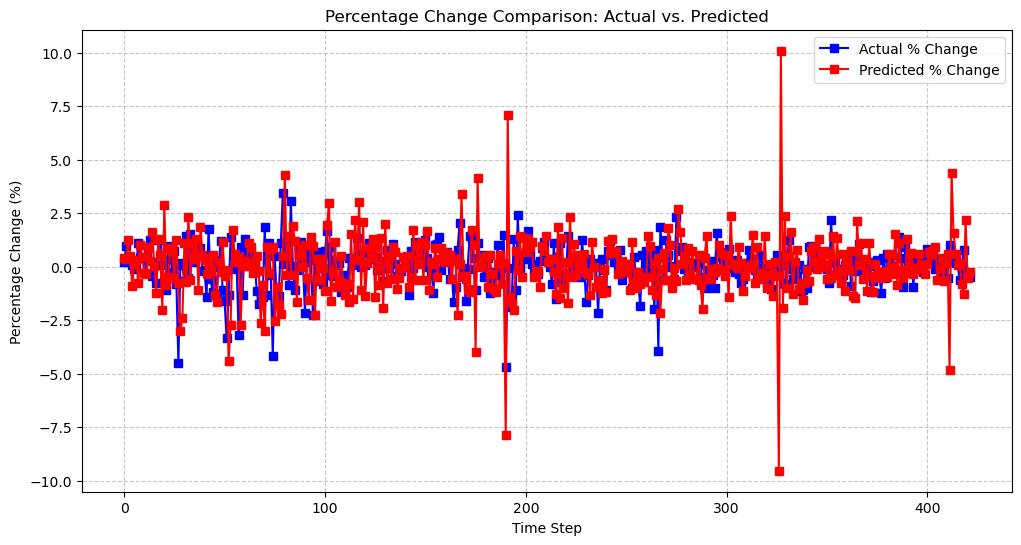

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-07-11      1151.769999         1148.772939
1   2023-07-12      1154.200033         1153.585684
2   2023-07-13      1165.420009         1157.555944
3   2023-07-14      1168.400035         1172.152333
4   2023-07-17      1173.130004         1177.840242
..         ...              ...                 ...
418 2025-03-14      1326.150001         1295.694382
419 2025-03-17      1336.259972         1279.326240
420 2025-03-18      1330.969991         1307.173940
421 2025-03-19      1324.629967         1300.260031
422 2025-03-20      1318.079998         1296.850015

[423 rows x 3 columns]


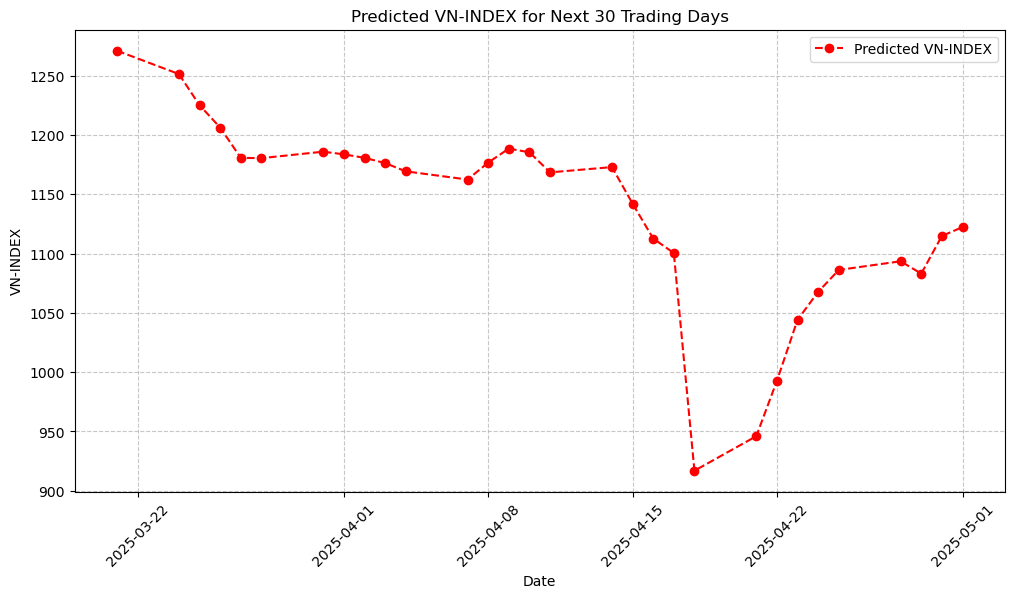

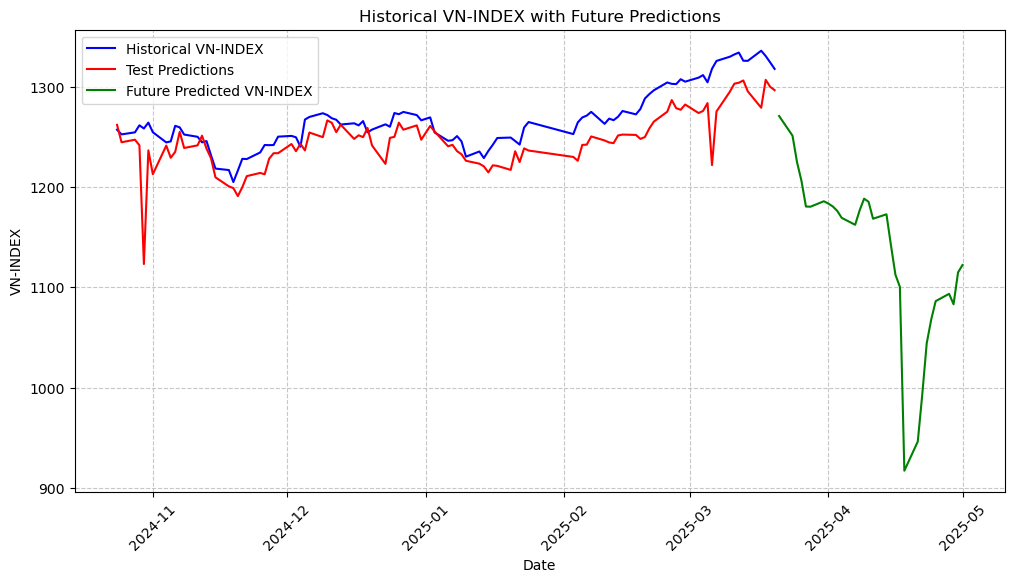

         Date  Predicted VN-INDEX
0  2025-03-21         1271.077581
1  2025-03-24         1251.414107
2  2025-03-25         1225.142318
3  2025-03-26         1206.299285
4  2025-03-27         1180.719457
5  2025-03-28         1180.496947
6  2025-03-31         1185.960188
7  2025-04-01         1183.686227
8  2025-04-02         1180.784121
9  2025-04-03         1176.362059
10 2025-04-04         1169.370076
11 2025-04-07         1162.448537
12 2025-04-08         1176.777405
13 2025-04-09         1188.543983
14 2025-04-10         1185.420523
15 2025-04-11         1168.499228
16 2025-04-14         1172.954200
17 2025-04-15         1142.150135
18 2025-04-16         1112.728296
19 2025-04-17         1100.472614
20 2025-04-18          916.920927
21 2025-04-21          946.037018
22 2025-04-22          992.735766
23 2025-04-23         1044.177894
24 2025-04-24         1067.734094
25 2025-04-25         1086.226984
26 2025-04-28         1093.530342
27 2025-04-29         1083.124334
28 2025-04-30 

In [22]:
# 📊 Select additional VN-INDEX statistics for prediction
data = df_1

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = transformer_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Train Loss: 0.0355, Val Loss: 0.0059
Epoch 2/50, Train Loss: 0.0139, Val Loss: 0.0021
Epoch 3/50, Train Loss: 0.0084, Val Loss: 0.0017
Epoch 4/50, Train Loss: 0.0058, Val Loss: 0.0016
Epoch 5/50, Train Loss: 0.0047, Val Loss: 0.0034
Epoch 6/50, Train Loss: 0.0038, Val Loss: 0.0013
Epoch 7/50, Train Loss: 0.0029, Val Loss: 0.0010
Epoch 8/50, Train Loss: 0.0026, Val Loss: 0.0020
Epoch 9/50, Train Loss: 0.0024, Val Loss: 0.0009
Epoch 10/50, Train Loss: 0.0022, Val Loss: 0.0012
Epoch 11/50, Train Loss: 0.0020, Val Loss: 0.0008
Epoch 12/50, Train Loss: 0.0018, Val Loss: 0.0007
Epoch 13/50, Train Loss: 0.0018, Val Loss: 0.0006
Epoch 14/50, Train Loss: 0.0016, Val Loss: 0.0006
Epoch 15/50, Train Loss: 0.0015, Val Loss: 0.0005
Epoch 16/50, Train Loss: 0.0014, Val Loss: 0.0008
Epoch 17/50, Train Loss: 0.0013, Val Loss: 0.0005
Epoch 18/50, Train Loss: 0.0013, Val Loss: 0.0006
Epoch 19/50, Train Loss: 0.0012, Val Loss: 0.0006
Epoch 20/50, Train Loss: 0.0012, Val Loss: 0.0004
Epoch 21/

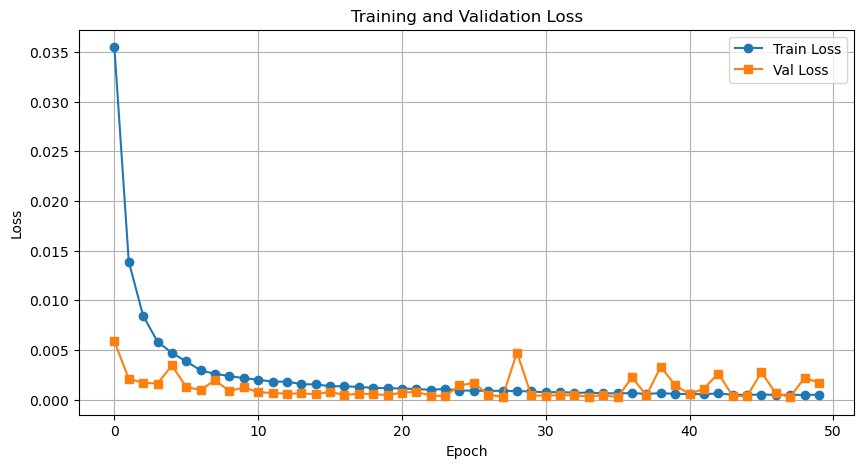

RMSE: 51.3168, MAE: 47.7951, R²: 0.3486


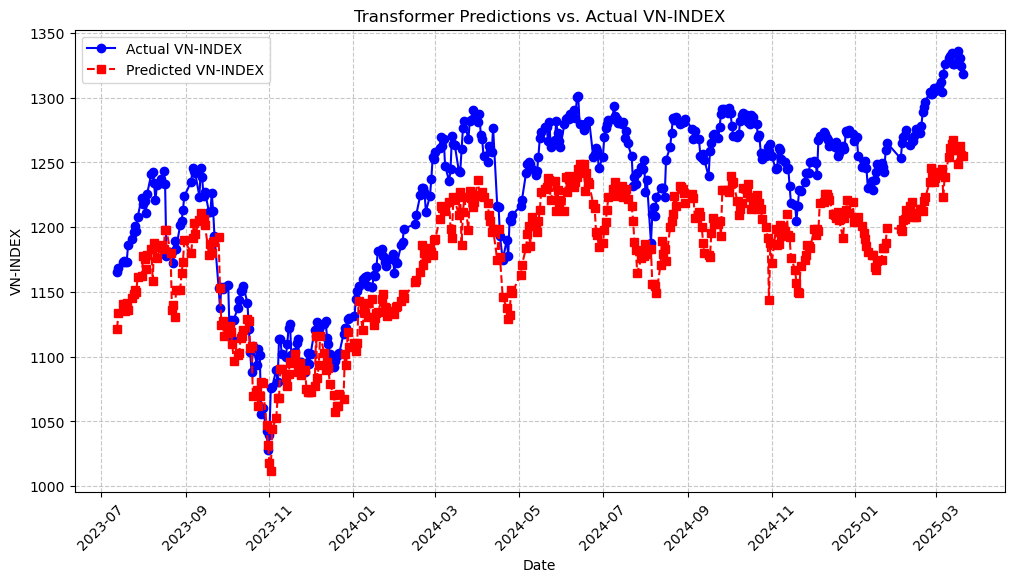

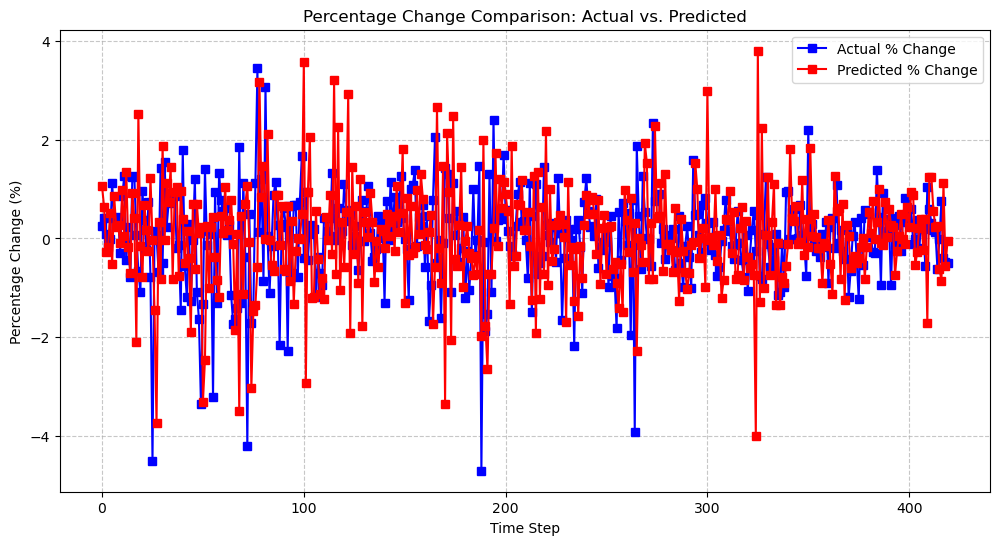

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-07-13      1165.420009         1121.683868
1   2023-07-14      1168.400035         1133.506092
2   2023-07-17      1173.130004         1140.801512
3   2023-07-18      1174.090025         1137.641828
4   2023-07-19      1172.980020         1135.641553
..         ...              ...                 ...
416 2025-03-14      1326.150001         1259.665771
417 2025-03-17      1336.259972         1248.849503
418 2025-03-18      1330.969991         1262.742524
419 2025-03-19      1324.629967         1255.710540
420 2025-03-20      1318.079998         1255.070218

[421 rows x 3 columns]


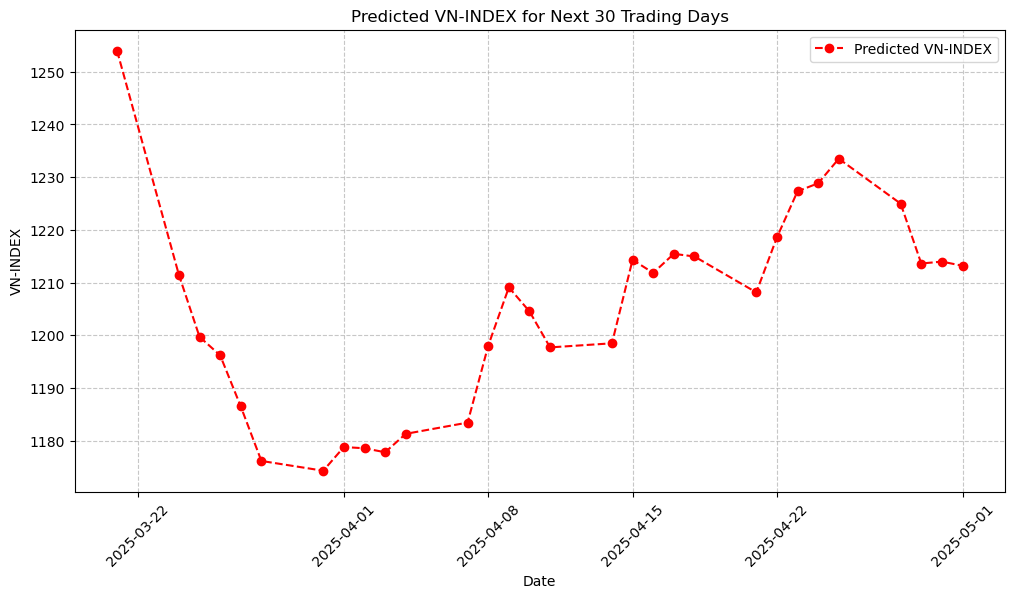

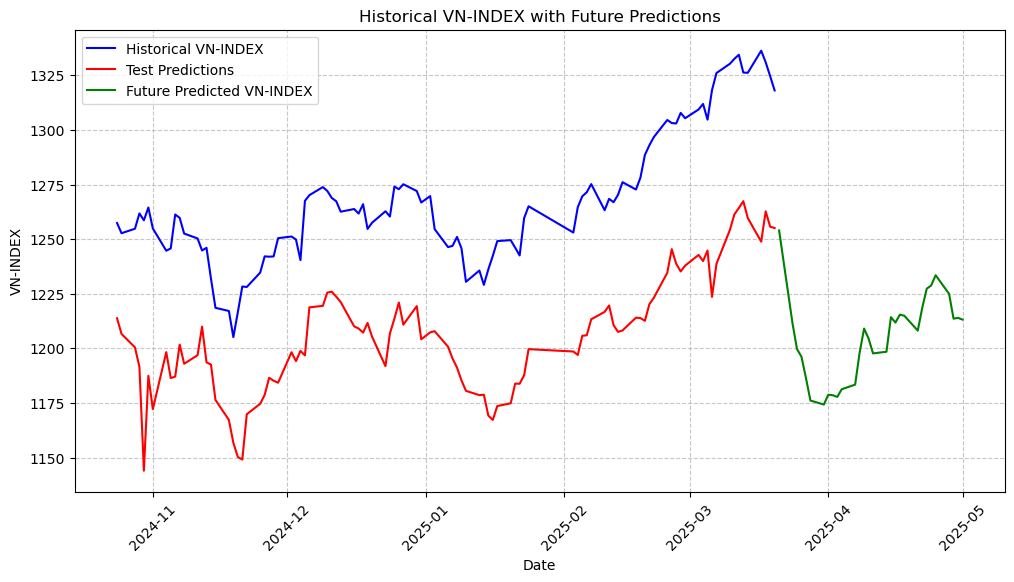

         Date  Predicted VN-INDEX
0  2025-03-21         1253.982410
1  2025-03-24         1211.440746
2  2025-03-25         1199.685884
3  2025-03-26         1196.184304
4  2025-03-27         1186.474650
5  2025-03-28         1176.141168
6  2025-03-31         1174.287100
7  2025-04-01         1178.783153
8  2025-04-02         1178.545537
9  2025-04-03         1177.793381
10 2025-04-04         1181.287022
11 2025-04-07         1183.417011
12 2025-04-08         1198.017639
13 2025-04-09         1209.076301
14 2025-04-10         1204.520363
15 2025-04-11         1197.689231
16 2025-04-14         1198.464046
17 2025-04-15         1214.311946
18 2025-04-16         1211.821332
19 2025-04-17         1215.440217
20 2025-04-18         1214.939551
21 2025-04-21         1208.126916
22 2025-04-22         1218.559823
23 2025-04-23         1227.307991
24 2025-04-24         1228.833034
25 2025-04-25         1233.490246
26 2025-04-28         1224.966129
27 2025-04-29         1213.604570
28 2025-04-30 

In [23]:
# 📊 Select additional VN-INDEX statistics for prediction
data = lag_features_indicators(df_1, ['VN_Index_Close'])

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = transformer_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [24]:
# 📊 Select additional VN-INDEX statistics for prediction
data = lag_features_indicators(df_1, df_1.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = transformer_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

TypeError: 'DataFrame' object cannot be interpreted as an integer

In [ ]:
# 📂 Load dataset
file_path_2 = "../ready_data/vn_index_external_data.csv"
df_2 = pd.read_csv(file_path_2)
df_2 = quicky_data(df_2)

In [ ]:
data = df_2

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = transformer_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [ ]:
data = lag_features_indicators(df_2, ['VN_Index_Close'])

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = transformer_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [ ]:
data = lag_features_indicators(df_2, df_2.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = transformer_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [ ]:
# 📂 Load dataset
file_path_3 = "../ready_data/merged_data.csv"
df_3 = pd.read_csv(file_path_3)
df_3 = quicky_data(df_3)

In [ ]:
data = df_3

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = transformer_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [ ]:
data = lag_features_indicators(df_3, ['VN_Index_Close'])

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = transformer_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [ ]:
data = lag_features_indicators(df_3, df_3.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = transformer_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [ ]:
data = lag_features_indicators(df_3, df_1.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = transformer_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [ ]:
data = lag_features_indicators(df_3, df_2.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = transformer_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)